In [2]:
%load_ext autoreload
%autoreload 2

from boolrank import *
from my_processing import paths_to_dataset
import numpy as np

batch_size = 2
# epochs = 5 * batch_size
epochs = 10
lr = 1e-7
loss = "siglip"
# loss = "clip"
eval_batch = 30
power = 1

bool_key = "bool_query"
nl_key = "nl_query"
qual_key = "quality"

data_path = "training"
path = "data/{}.jsonl"
pubmed = path.format(data_path)
TAR = path.format("TAR_data")
sysrev = path.format("sysrev_conv")
train_sources = ['pubmed-searchrefiner']
train_sources += ['pubmed-query', 'raw-jsonl']
dataset = paths_to_dataset([pubmed, TAR, sysrev],
                           test_only_sources=['TAR', 'sysrev'],
                           train_sources=train_sources)

print(dataset)
weights = np.array(dataset["train"][qual_key])**power

# model = DualSiglip2Model('BAAI/llm-embedder', loss)
model = DualSiglip2Model('BAAI/bge-small-en-v1.5', loss)
# model = DualSiglip2Model('dmis-lab/biobert-v1.1', loss)
lr_n = "" if lr == 1e-7 else f"lr{lr:.0E}_"
b_n = "" if batch_size == 2 else f"b{batch_size}_"
pow_n = "" if power == 1 else f"^{power}"
data_n = '_'.join(k[:10] for k in np.unique(dataset['train']['source']))

model_name = model.model_name.split("/")[-1]
model_path = f"{loss}/{model_name}/{b_n + lr_n}({data_n}){pow_n}"
print(model_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[0 1]


Finding similar: 100%|██████████| 2088/2088 [00:00<00:00, 4107.93it/s]


[ 0  1  2  3  4  5  6  7  8  9 10 11]


Finding similar: 100%|██████████| 343/343 [00:00<00:00, 14215.87it/s]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


Finding similar: 100%|██████████| 79/79 [00:00<00:00, 26339.43it/s]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


Finding similar: 100%|██████████| 50/50 [00:00<00:00, 49991.70it/s]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


Finding similar: 100%|██████████| 40/40 [00:00<?, ?it/s]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


Finding similar: 100%|██████████| 22566/22566 [01:14<00:00, 303.85it/s]


DatasetDict({
    train: Dataset({
        features: ['nl_query', 'bool_query', 'source', 'quality', 'pmid'],
        num_rows: 22566
    })
    test: {'pubmed-query': Dataset({
        features: ['nl_query', 'bool_query', 'source', 'quality', 'pmid', '__index_level_0__'],
        num_rows: 2100
    }), 'pubmed-searchrefiner': Dataset({
        features: ['nl_query', 'bool_query', 'source', 'quality', 'pmid', '__index_level_0__'],
        num_rows: 210
    }), 'raw-jsonl': Dataset({
        features: ['nl_query', 'bool_query', 'source', 'quality', 'pmid', '__index_level_0__'],
        num_rows: 90
    }), 'TAR': Dataset({
        features: ['nl_query', 'bool_query', 'source', '__index_level_0__'],
        num_rows: 60
    }), 'sysrev': Dataset({
        features: ['id', 'link_to_review', 'nl_query', 'search_name', 'Date_from', 'Date_to', 'bool_query', 'seed_studies', 'included_studies', 'edited_search', 'source', '__index_level_0__'],
        num_rows: 60
    })}
})
siglip/bge-small-en

In [ ]:
import os
import re
from transformers import Trainer, TrainingArguments
from transformers.utils.notebook import NotebookProgressCallback
from custom_trainer import NotebookProgressCallbackNoTable, WandbCallbackAveraged
from evaluation import compute_metrics
from torch.utils.data import WeightedRandomSampler

sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

class WeightedTrainer(Trainer):
    def get_train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            sampler=sampler,
            collate_fn=self.data_collator,
        )

os.environ["WANDB_PROJECT"] = "Boolean-Ranking"
os.environ["WANDB_LOG_MODEL"] = "false"

# epochs = 10
training_args = TrainingArguments(
    output_dir="models/" + model_path,
    per_device_train_batch_size=batch_size,
    num_train_epochs=epochs,
    learning_rate=lr,
    save_steps=1000,
    save_total_limit=1,
    remove_unused_columns=False,
    bf16=True,
    optim="adamw_bnb_8bit",
    logging_steps=100,
    # report_to="wandb",
    eval_steps=200,
    eval_strategy="steps",
    eval_on_start=True,
    per_device_eval_batch_size=eval_batch,
    run_name=model_path,
    # max_steps=1000,
)

def collate_fn(batch):
    return {
        "in_bool": [ex[bool_key] for ex in batch],
        # "in_text": [re.sub("\[.*?\]", "", ex[nl_key]) for ex in batch],
        "in_text": [ex[nl_key] for ex in batch],
        # "weights": np.array([ex.get(qual_key, 0) for ex in batch]),
    }

# trainer = Trainer(
trainer = WeightedTrainer(
    model,
    training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)

trainer.remove_callback(NotebookProgressCallback)
trainer.add_callback(NotebookProgressCallbackNoTable)
trainer.add_callback(WandbCallbackAveraged)

# trainer.evaluate(dataset["test"]["pubmed-query"].select(range(10)))
trainer.train()
# try: trainer.train(resume_from_checkpoint=True)
# except: trainer.train(resume_from_checkpoint=False)

wandb: Currently logged in as: simon-doehl (simon-doehl-ai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


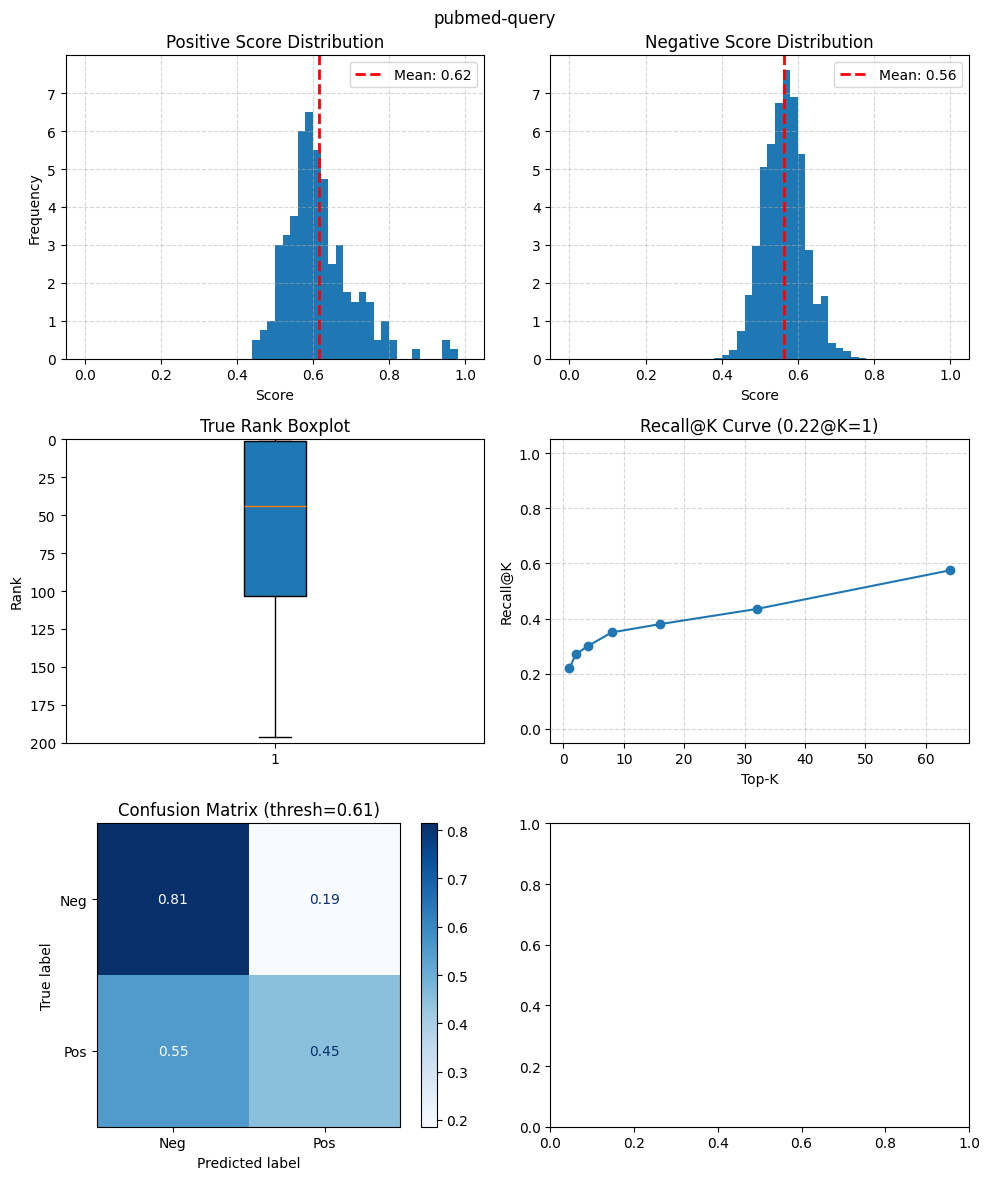

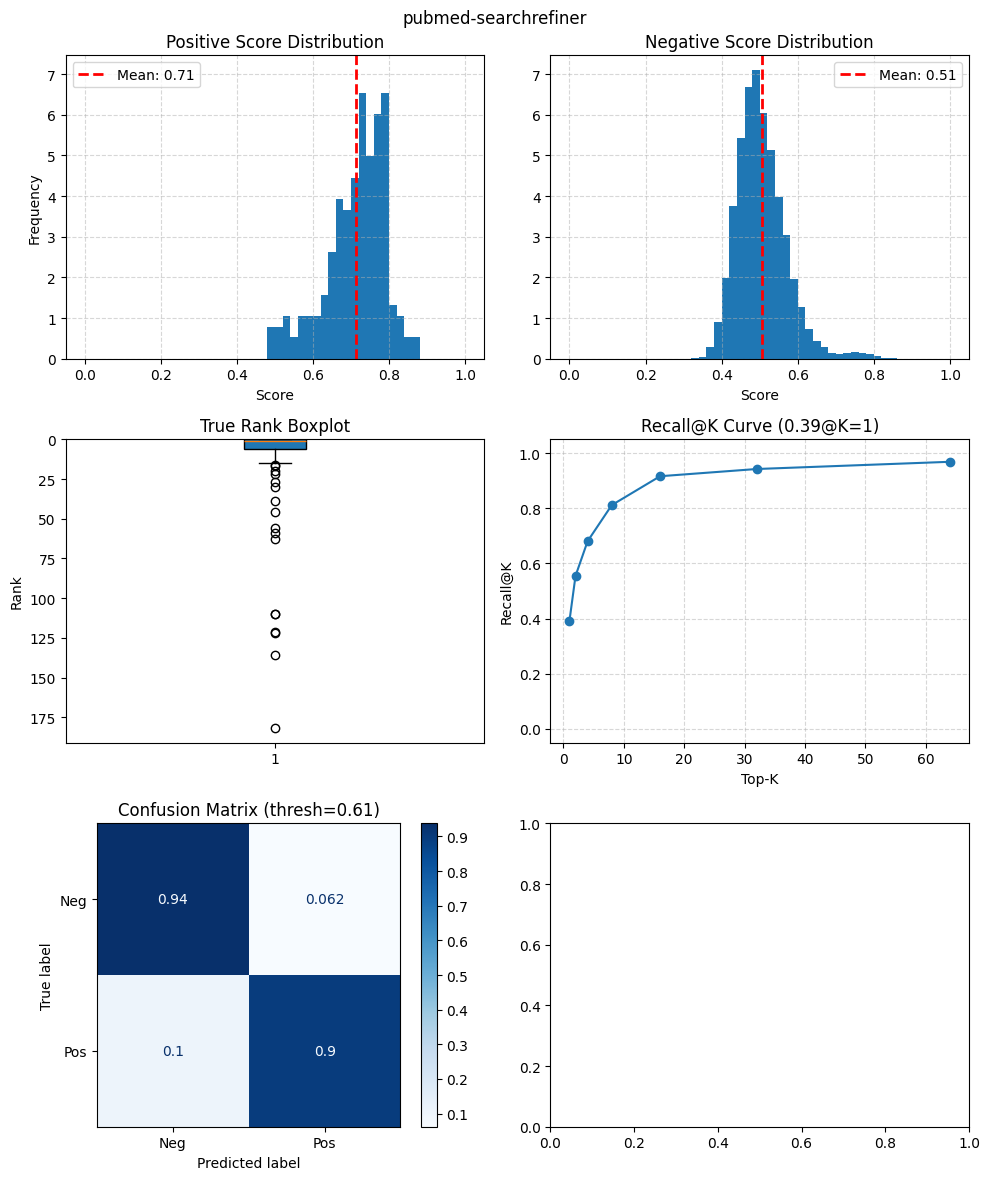

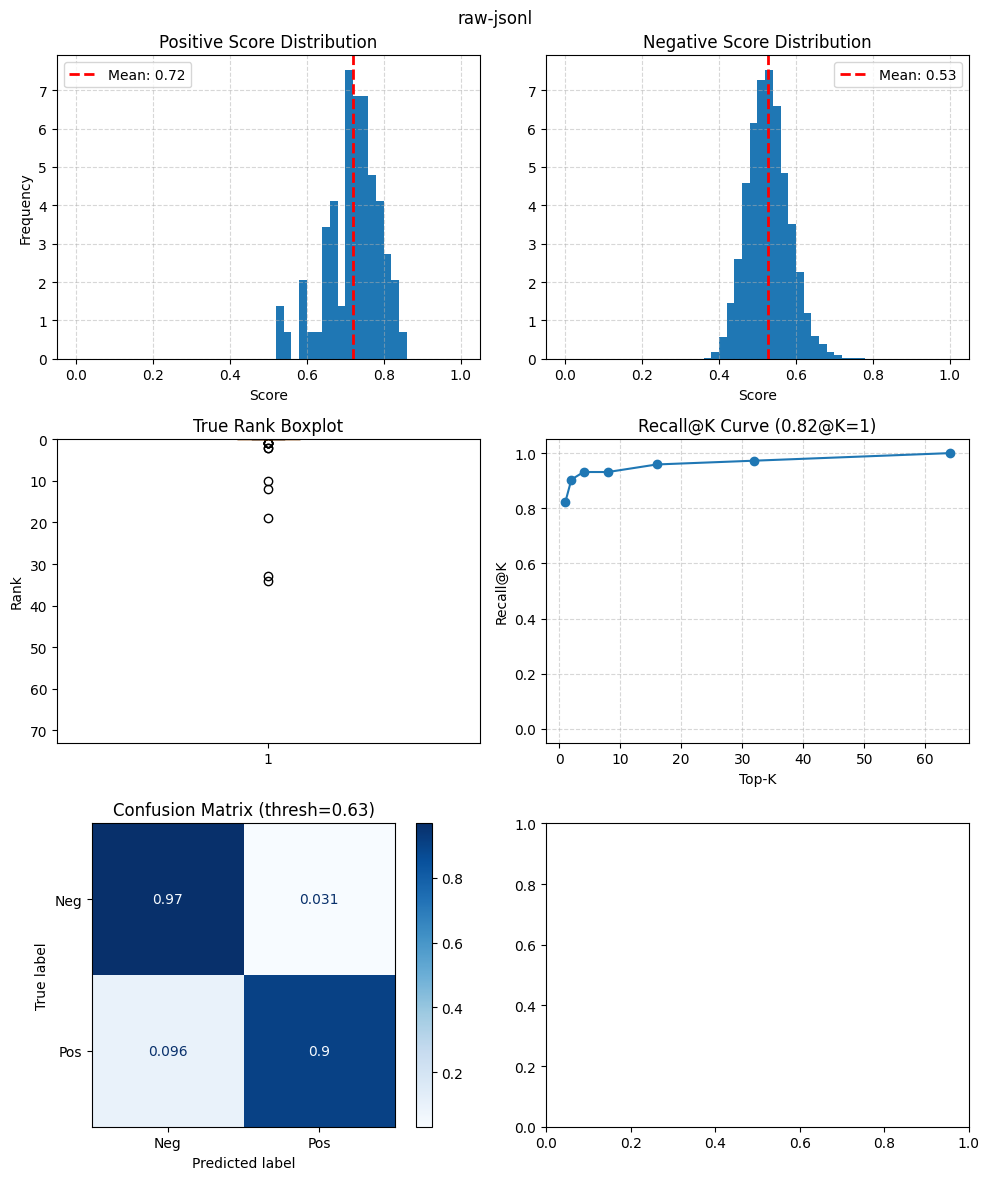

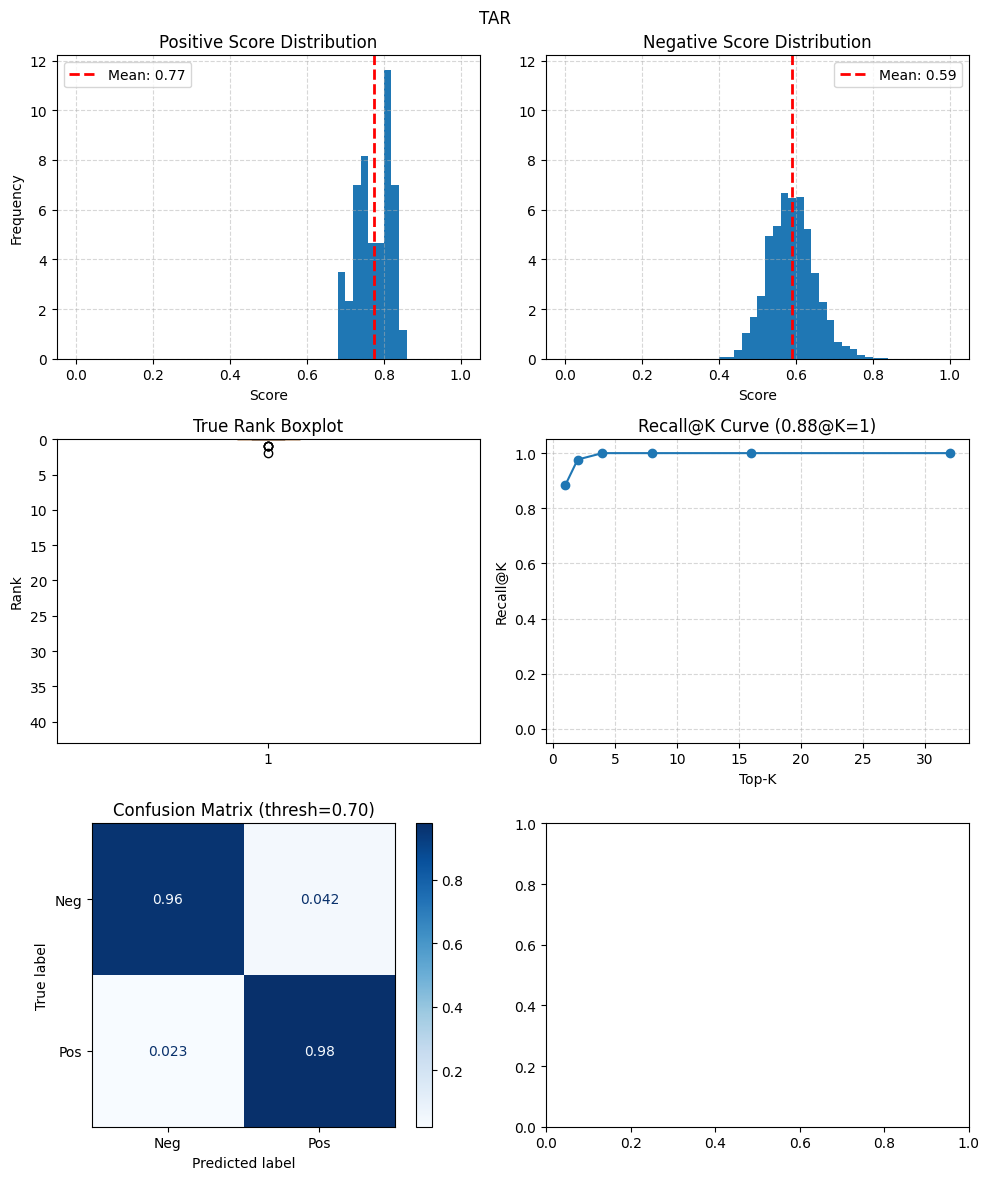

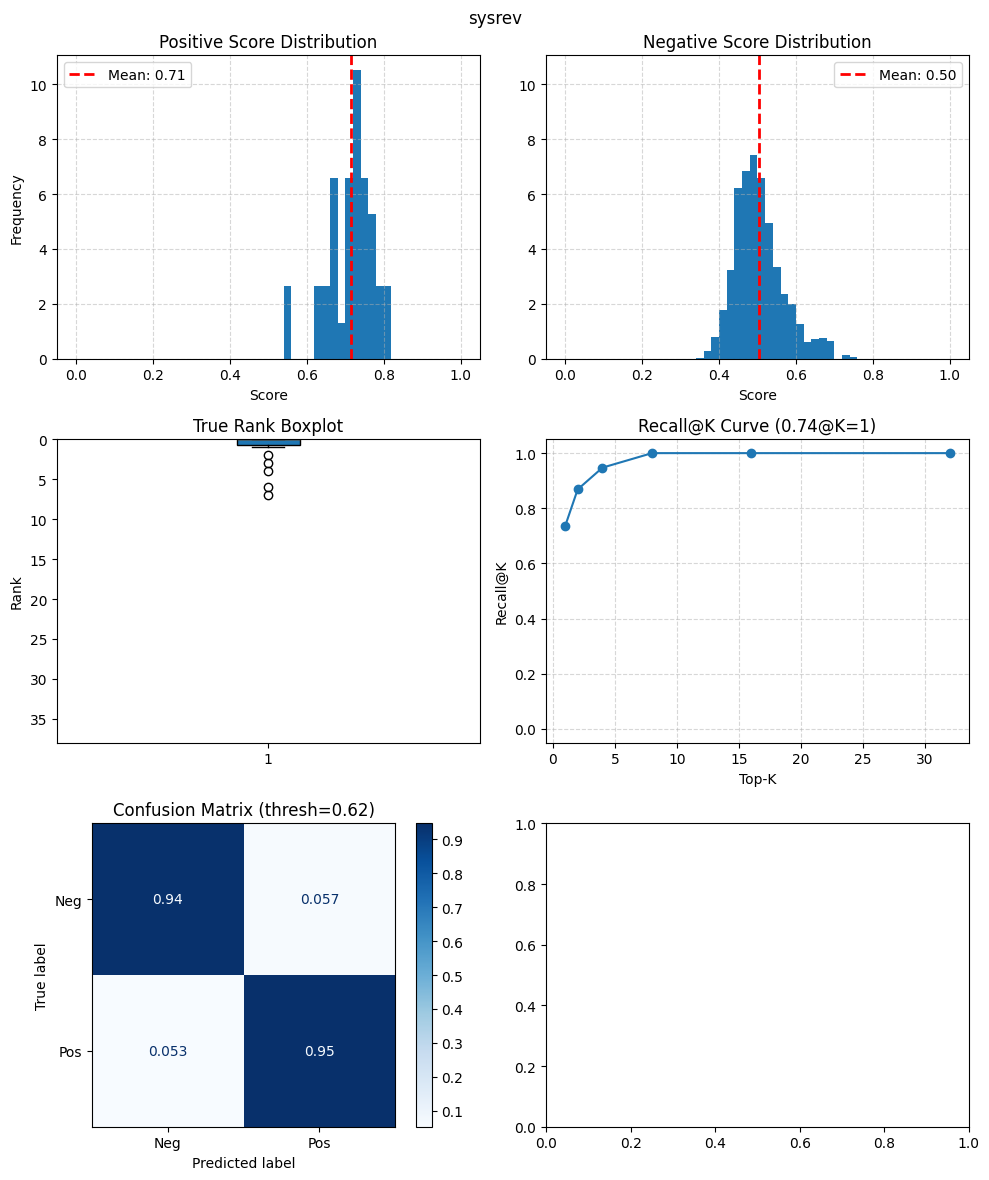

In [ ]:
from evaluation import evaluate
# paths = [r"models/siglip2/old/b2-bf-8b/e4", r"models/siglip2/old/b3-bf-8b"]
paths = [None]
amt = eval_batch
format = "pdf"
for path in paths:
    if path is not None:
        model.load(path + "/model.safetensors")
        print(path)
    else: path = model_path

    for key, data in dataset["test"].items():
        res = evaluate(model, data[bool_key][:amt], data[nl_key][:amt], plot=True, title=key)
        res["plot"].savefig(f"models/{path}/test_stats.{format}", format=format)